## imports

In [1]:
import os
import sys
from absl import logging
import jax
from matplotlib import pyplot as plt
import numpy as np
import tqdm

In [2]:
# clone repository and pull latest changes
![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer
!cd vision_transformer && git pull

Already up to date.


In [3]:
!pip install -qr vision_transformer/vit_jax/requirements.txt

In [4]:
!pip install tensorflow_text
!git clone https://github.com/google/flaxformer.git
!cd flaxformer && pip install '.[testing]'
!pip install git+https://github.com/google/flax

fatal: destination path 'flaxformer' already exists and is not an empty directory.
Processing /content/flaxformer
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Cloning https://github.com/google-research/t5x to /tmp/pip-install-9k_9z7l7/t5x_c3cadc4b1aba4ce9ad2039483ee8bfba
  Running command git clone -q https://github.com/google-research/t5x /tmp/pip-install-9k_9z7l7/t5x_c3cadc4b1aba4ce9ad2039483ee8bfba
  Cloning https://github.com/google/CommonLoopUtils to /tmp/pip-install-9k_9z7l7/clu_b182f4b0a7234afeb4efa39d48400824
  Running command git clone -q https://github.com/google/CommonLoopUtils /tmp/pip-install-9k_9z7l7/clu_b182f4b0a7234afeb4efa

In [5]:
# import files from the repository
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint
from vit_jax import input_pipeline
from vit_jax import utils
from vit_jax import models
from vit_jax import momentum_clip
from vit_jax import train
from vit_jax.configs import common as common_config
from vit_jax.configs import models as models_config

In [6]:
# download a pre-trained model
model_name = 'ViT-B_32'
![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet21k/"$model_name".npz .
assert os.path.exists(f'{model_name}.npz')

Copying gs://vit_models/imagenet21k/ViT-B_32.npz...
\ [1 files][400.0 MiB/400.0 MiB]                                                
Operation completed over 1 objects/400.0 MiB.                                    


## helper functions for images

In [7]:
labelnames = dict(
    # https://www.cs.toronto.edu/~kriz/cifar.html
    cifar10=('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
    # https://www.cs.toronto.edu/~kriz/cifar.html
    cifar100=('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm')
)

def make_label_getter(dataset):
    """
    Returns a function converting label indices to names.
    """
    def getter(label):
        if dataset in labelnames:
            return labelnames[dataset][label]
        return f'label={label}'
    return getter

def show_img(img, ax=None, title=None):
    """
    Shows a single image.
    """
    if ax is None:
        ax = plt.gca()
    ax.imshow(img[...])
    ax.set_xticks([])
    ax.set_yticks([])
    if title:
        ax.set_title(title)

def show_img_grid(imgs, titles):
    """
    Shows a grid of images.
    """
    n = int(np.ceil(len(imgs)**.5))
    _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
    for i, (img, title) in enumerate(zip(imgs, titles)):
        img = (img + 1) / 2  # Denormalize
        show_img(img, axs[i // n][i % n], title)

## load data

In [8]:
dataset = 'cifar10'
batch_size = 512
config = common_config.with_dataset(common_config.get_config(), dataset)
num_classes = input_pipeline.get_dataset_info(dataset, 'train')['num_classes']
config.batch = batch_size
config.pp.crop = 224

In [9]:
ds_train = input_pipeline.get_data_from_tfds(config=config, mode='train')
ds_test = input_pipeline.get_data_from_tfds(config=config, mode='test')

del config  # only needed to instantiate datasets.

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteU9KXJJ/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteU9KXJJ/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [10]:
# fetch a batch of test images for illustration purposes.
batch = next(iter(ds_test.as_numpy_iterator()))
batch['image'].shape

(1, 512, 224, 224, 3)

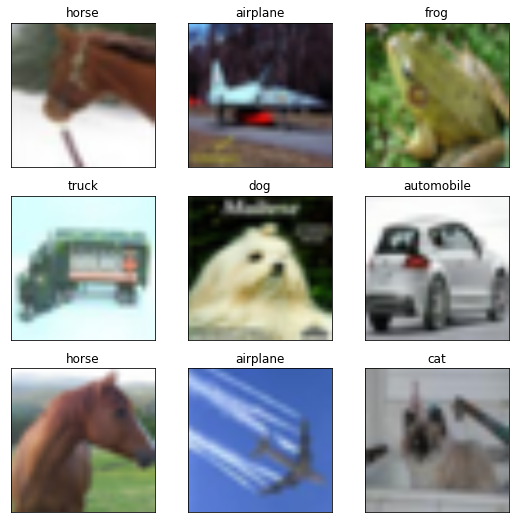

In [11]:
# show some images with their labels.
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

## load pre-trained model

In [12]:
model_config = models_config.MODEL_CONFIGS[model_name]
model_config

classifier: token
hidden_size: 768
model_name: ViT-B_32
patches:
  size: !!python/tuple
  - 32
  - 32
representation_size: null
transformer:
  attention_dropout_rate: 0.0
  dropout_rate: 0.0
  mlp_dim: 3072
  num_heads: 12
  num_layers: 12

In [13]:
# load model definition & initialize random parameters
model = models.VisionTransformer(num_classes=num_classes, **model_config)
variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    # discard the "num_local_devices" dimension of the batch for initialization
    batch['image'][0, :1],
    train=False,
), backend='cpu')()

# load and convert pretrained checkpoint
params = checkpoint.load_pretrained(
    pretrained_path=f'{model_name}.npz',
    init_params=variables['params'],
    model_config=model_config,
)

## evaluation

In [14]:
# move data onto device
import flax
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['head']['bias']).__name__, 
      params['head']['bias'].shape)
print('params_repl.cls:', type(params_repl['head']['bias']).__name__,
      params_repl['head']['bias'].shape)

# map forward call onto all available devices
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
    dict(params=params), inputs, train=False))

params.cls: DeviceArray (10,)
params_repl.cls: ShardedDeviceArray (1, 10)


In [15]:
def get_accuracy(params_repl):
    """
    Returns accuracy evaluated on the test set.
    """
    good = total = 0
    steps = input_pipeline.get_dataset_info(dataset, 'test')['num_examples'] // batch_size
    for _, batch in zip(tqdm.trange(steps), ds_test.as_numpy_iterator()):
        predicted = vit_apply_repl(params_repl, batch['image'])
        is_same = predicted.argmax(axis=-1) == batch['label'].argmax(axis=-1)
        good += is_same.sum()
        total += len(is_same.flatten())
    return good / total

In [16]:
# performance without fine-tuning
get_accuracy(params_repl)

100%|██████████| 19/19 [11:36<00:00, 36.65s/it]


DeviceArray(0.10063734, dtype=float32)

## fine-tuning

In [17]:
total_steps = 100
warmup_steps = 5
decay_type = 'cosine'
grad_norm_clip = 1
accum_steps = 64
base_lr = 0.03

In [18]:
lr_fn = utils.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)
update_fn_repl = train.make_update_fn(
    apply_fn=model.apply, accum_steps=accum_steps, lr_fn=lr_fn)
opt = momentum_clip.Optimizer(grad_norm_clip=grad_norm_clip).create(params)
opt_repl = flax.jax_utils.replicate(opt)

/usr/local/lib/python3.7/dist-packages/flax/optim/base.py:52: DeprecationWarning: Use `optax` instead of `flax.optim`. Refer to the update guide https://flax.readthedocs.io/en/latest/howtos/optax_update_guide.html for detailed instructions.
  'for detailed instructions.', DeprecationWarning)


In [19]:
update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(0))

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/jax/interpreters/mlir.py:478: UserWarning: Some donated buffers were not usable: ShapedArray(int32[]), ShapedArray(bfloat16[768]), ShapedArray(bfloat16[768]), ShapedArray(bfloat16[768]), ShapedArray(bfloat16[768]), ShapedArray(bfloat16[768]), ShapedArray(bfloat16[768]), ShapedArray(bfloat16[3072]), ShapedArray(bfloat16[768,3072]), ShapedArray(bfloat16[768]), ShapedArray(bfloat16[3072,768]), ShapedArray(bfloat16[12,64]), ShapedArray(bfloat16[768,12,64]), ShapedArray(bfloat16[768]), ShapedArray(bfloat16[12,64,768]), ShapedArray(bfloat16[12,64]), ShapedArray(bfloat16[768,12,64]), ShapedArray(bfloat16[12,64]), ShapedArray(bfloat16[768,12,64]), ShapedArray(bfloat16[768]), ShapedArray(bfloat16[768]), ShapedArray(bfloat16[768]), ShapedArray(bfloat16[768]), ShapedArray(bfloat16[3072]), ShapedArray(bfloat16[768,3072]), ShapedArray(bfloat16[768]), ShapedArray(bfloat16[3072,768]), ShapedArray(bfloat16[12,64]), ShapedArr

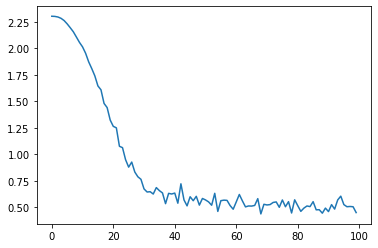

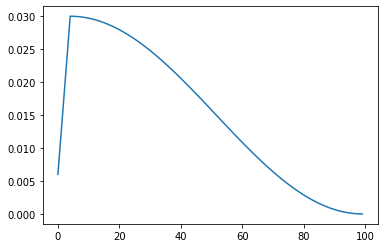

In [20]:
losses = []
lrs = []
for step, batch in zip(
    tqdm.trange(1, total_steps + 1),
    ds_train.as_numpy_iterator(),
):

  opt_repl, loss_repl, update_rng_repl = update_fn_repl(
      opt_repl, flax.jax_utils.replicate(step), batch, update_rng_repl)
  losses.append(loss_repl[0])
  lrs.append(lr_fn(step))

plt.plot(losses)
plt.figure()
plt.plot(lrs)

In [21]:
get_accuracy(opt_repl.target)

100%|██████████| 19/19 [11:29<00:00, 36.28s/it]


DeviceArray(0.9756373, dtype=float32)